In [1]:
import cv2
import numpy as np
import pprint
from pathlib import Path
from matplotlib import pyplot as plt
from BEV.bev_transform import BEV
from src.cap_aug import CAP_AUG, CAP_AUG_Multiclass
from src.utils import show_image, draw_bboxes, show_image_and_masks

# Load data

## Load destination image

In [2]:
DEST_DATASET_ROOT = Path('example_images/')

In [3]:
# dest_image_name = 'img_174124862194.png'
dest_image_name = 'img_900983.png'

dest_image_name = DEST_DATASET_ROOT / dest_image_name
image = cv2.imread(str(dest_image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

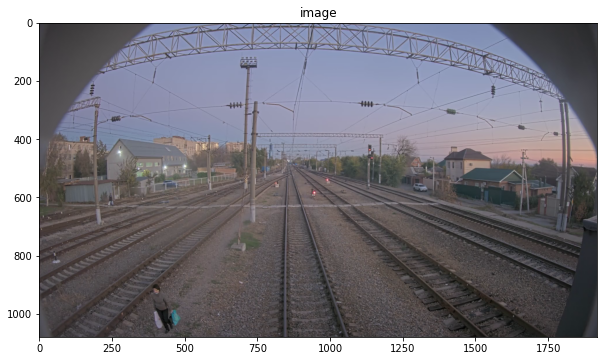

In [4]:
show_image(image)

## Get list of source images

In [5]:
HUMAN_DATASET_ROOT = Path('data/human_dataset_filtered/')
SOURCE_IMAGES = sorted(list(HUMAN_DATASET_ROOT.glob('*.png')))

# Bird's-eye view transformation

In [6]:
# Extrinsic camera parameters
camera_info = {'pitch' : -2 ,
               'yaw' : 0 ,
               'roll' : 0 ,
               'tx' : 0,
               'ty' : 5,
               'tz' : 0,
               'output_w': 1000, # output bev image shape
               'output_h': 1000}
calib_yaml_path=None # path to intrinsic parameters (see example in BEV/camera_intrinsic_params.yaml file)
                     # if calib_yaml_path is None, intrinsic params will be loaded from BEV/camera_intrinsic_params.yaml

bev_transform = BEV(camera_info=camera_info,
                    calib_yaml_path=calib_yaml_path)

## BEV image transformation

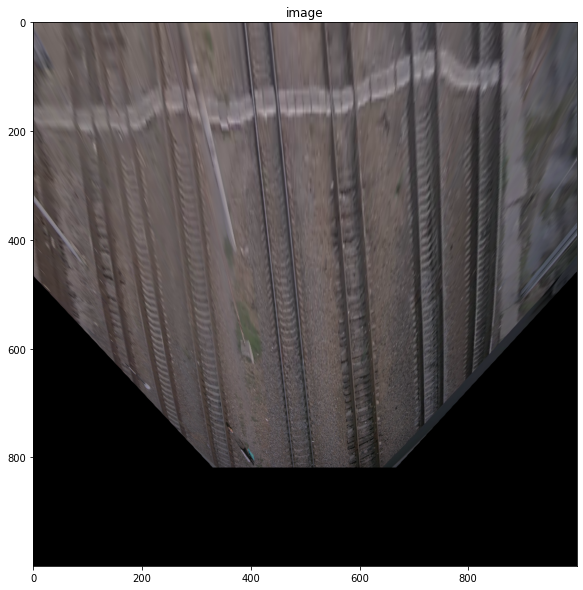

In [7]:
bev_image = bev_transform(image)
show_image(bev_image)

# CAP augmentation examples

## Example with BEV

In [8]:
cap_aug = CAP_AUG(SOURCE_IMAGES, bev_transform=bev_transform, 
                                               n_objects_range=[10,20], 
                                               h_range=[2.0, 2.5],
                                               x_range=[-25, 25],
                                               y_range=[10 ,50],
                                               z_range=[0, 0],
                                               histogram_matching=False,
                                               hm_offset=100,
                                               image_format='rgb')

In [9]:
result_image, result_coords, semantic_mask, instance_mask = cap_aug(image)

### Draw result

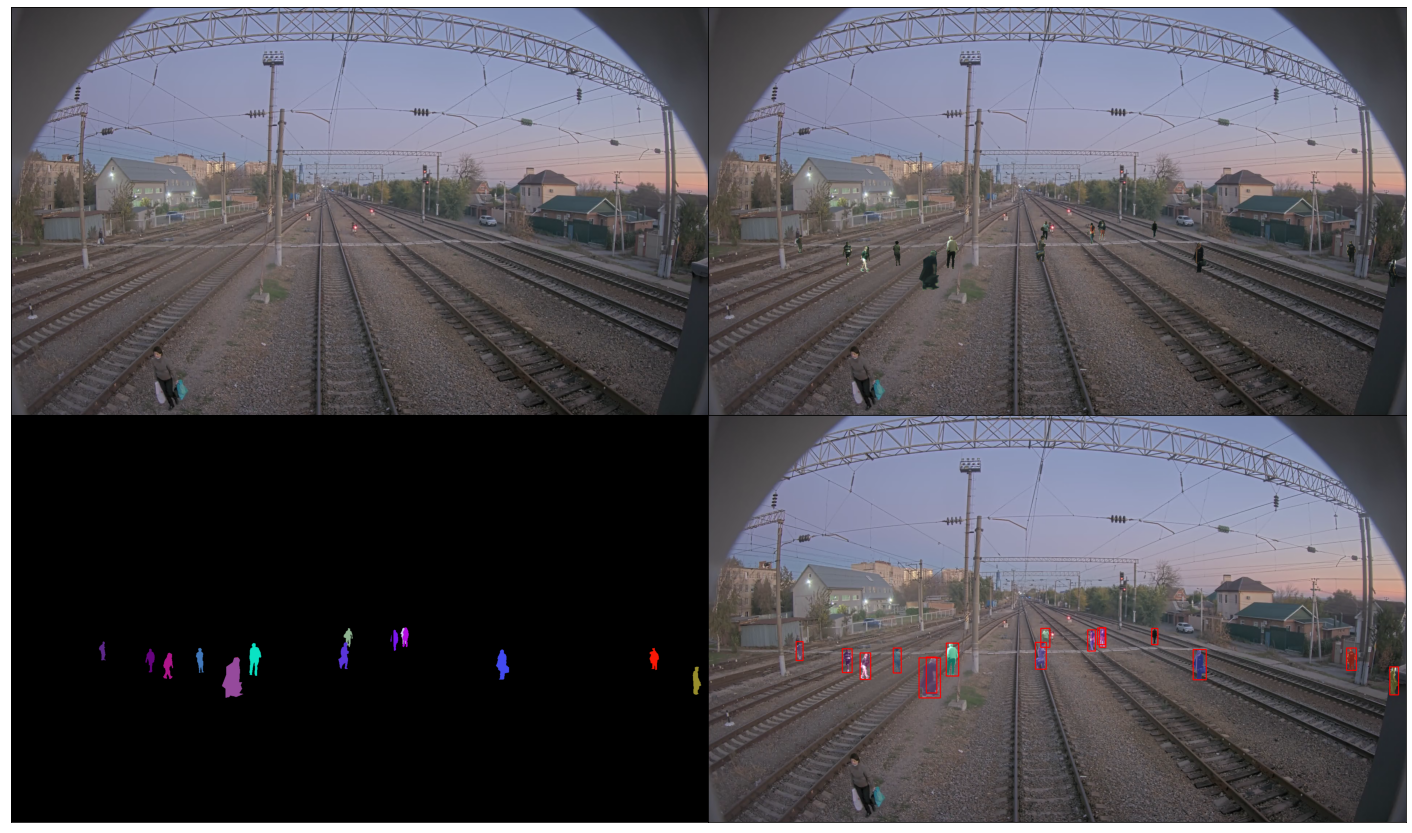

In [10]:
# Draw bounding boxes
result_image_vis, result_mask_vis = draw_bboxes(result_image, result_coords, mask=instance_mask)

show_image_and_masks(image, result_image, result_mask_vis, result_image_vis)
# plt.savefig('example_images/all.png', bbox_inches='tight')

## Example in pixel coordinates

Note : If bev_transform parameter is None, then x_range and y_range must be a list of integers and these parameters will mean range in x and y axis in the image coordinate system. h_range parameter also must be a list of interegers (pixel sizes of images)

In [18]:
cap_aug_pixels = CAP_AUG(SOURCE_IMAGES,  bev_transform=None, 
                                               n_objects_range=[10,20], 
                                               h_range=[100,101],
                                               x_range=[500, 1500],
                                               y_range=[600 ,1000])

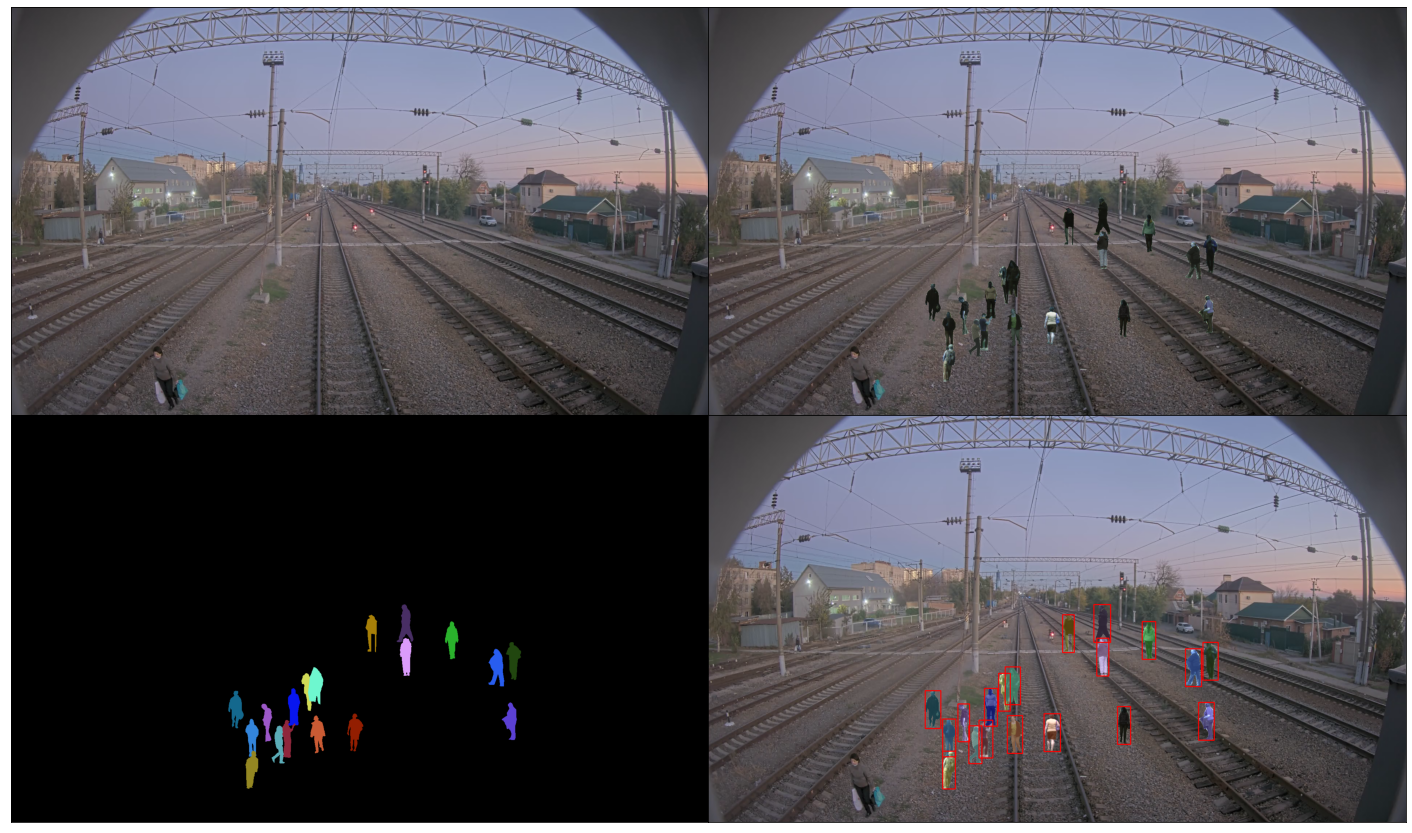

In [19]:
result_image, result_coords, semantic_mask, instance_mask = cap_aug_pixels(image)

# Draw bounding boxes
result_image_vis, result_mask_vis = draw_bboxes(result_image, result_coords, mask=instance_mask)

show_image_and_masks(image, result_image, result_mask_vis, result_image_vis)

## Multiple classes example

In [20]:
HUMAN_DATASET_ROOT = Path('data/human_dataset_filtered/')
HUMAN_SOURCE_IMAGES = sorted(list(HUMAN_DATASET_ROOT.glob('*.png')))

LIGHTS_DATASET_ROOT = Path('data/lights/')
LIGHTS_SOURCE_IMAGES = sorted(list(LIGHTS_DATASET_ROOT.glob('*.png')))

cap_augs = [
    CAP_AUG(HUMAN_SOURCE_IMAGES, bev_transform=bev_transform, 
                                               n_objects_range=[10,20], 
                                               h_range=[2.0, 2.5],
                                               x_range=[-25, 25],
                                               y_range=[10 ,50],
                                               z_range=[0, 0],
                                               image_format='rgb'),
    CAP_AUG(LIGHTS_SOURCE_IMAGES, bev_transform=bev_transform, 
                                               n_objects_range=[10,15], 
                                               h_range=[1.0, 1.2],
                                               x_range=[-5, 5],
                                               y_range=[20 ,40],
                                               z_range=[5, 8],
                                               image_format='rgb'),
]

probabilities = [1, 0.9]
class_idxs = [1, 2]

cap_multiclass = CAP_AUG_Multiclass(cap_augs, probabilities, class_idxs)

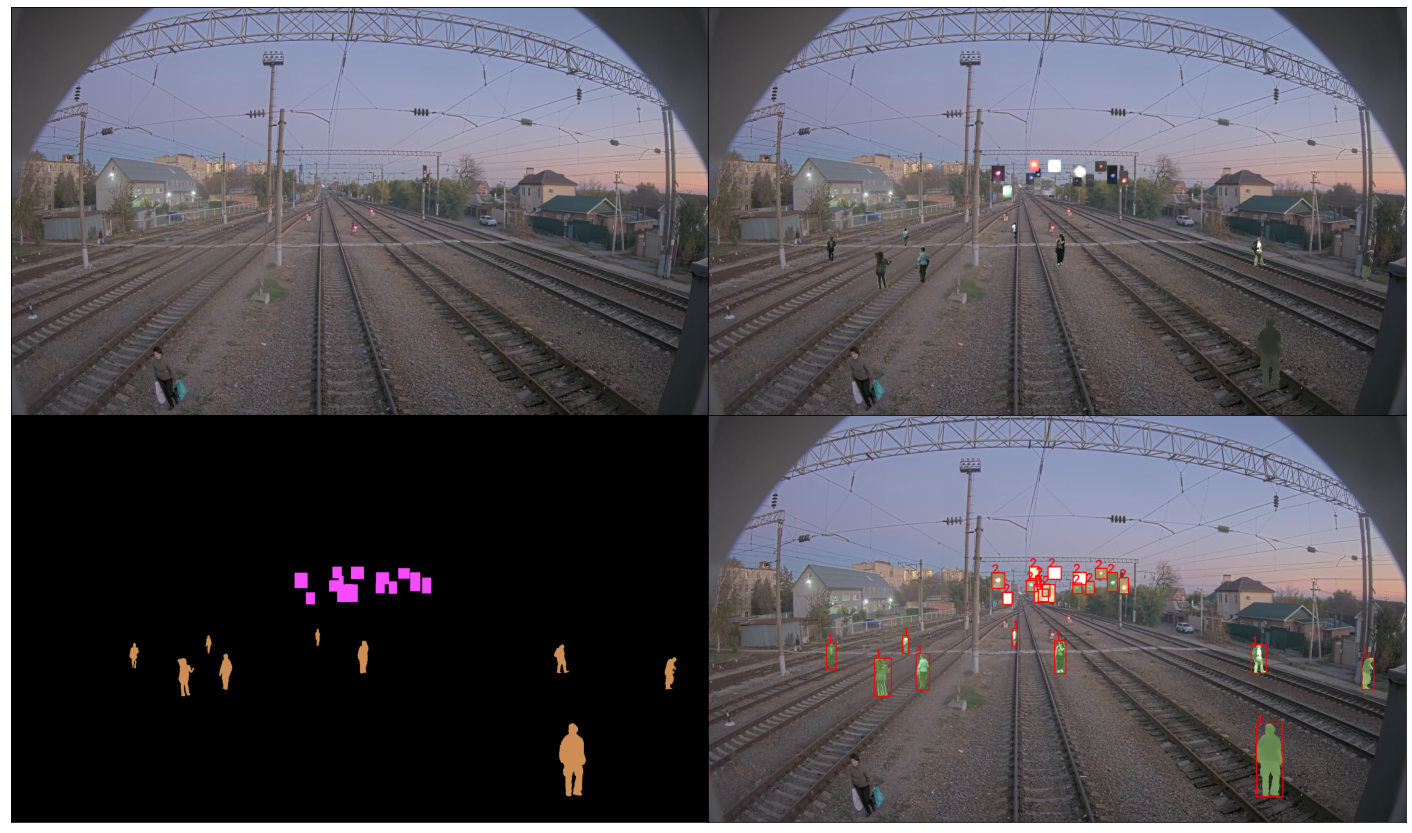

In [17]:
result_image, result_coords, semantic_mask, instance_mask = cap_multiclass(image)

# Draw bounding boxes
result_image_vis, result_mask_vis = draw_bboxes(result_image, result_coords, mask=semantic_mask)

show_image_and_masks(image, result_image, semantic_mask, result_image_vis, is_mask_semantic=True)

## Albumentations example

In [1]:
import cv2
import numpy as np
from pathlib import Path
from src.utils import show_image, draw_bboxes, show_image_and_masks
from src.cap_aug import CAP_Albu
import albumentations as A

In [9]:
DEST_DATASET_ROOT = Path('example_images/')
dest_image_name = 'img_900983.png'

dest_image_name = DEST_DATASET_ROOT / dest_image_name
image = cv2.imread(str(dest_image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

HUMAN_DATASET_ROOT = Path('data/human_dataset_filtered/')
SOURCE_IMAGES = sorted(list(HUMAN_DATASET_ROOT.glob('*.png')))
print(len(SOURCE_IMAGES))

2676


In [10]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRain( p=1.0, slant_lower=-5, slant_upper=5, drop_length=10, drop_width=1, drop_color=(255, 255, 255), blur_value=3, brightness_coefficient=0.699999988079071, rain_type='drizzle'),
    CAP_Albu(p=1, 
               source_images=SOURCE_IMAGES, 
               n_objects_range=[10,20], 
               h_range=[100,101],
               x_range=[500, 1500],
               y_range=[600 ,1000],
               class_idx=1)
], bbox_params=A.BboxParams(format='pascal_voc'))

bboxes = np.array([[375, 900, 500, 1079, 1]])
mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
mask[900:1079, 375:500] = 1

transformed = transform(image=image, bboxes=bboxes, mask=mask)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_mask = transformed['mask']

result_coords = np.array(transformed_bboxes).astype(int)[:,:4]

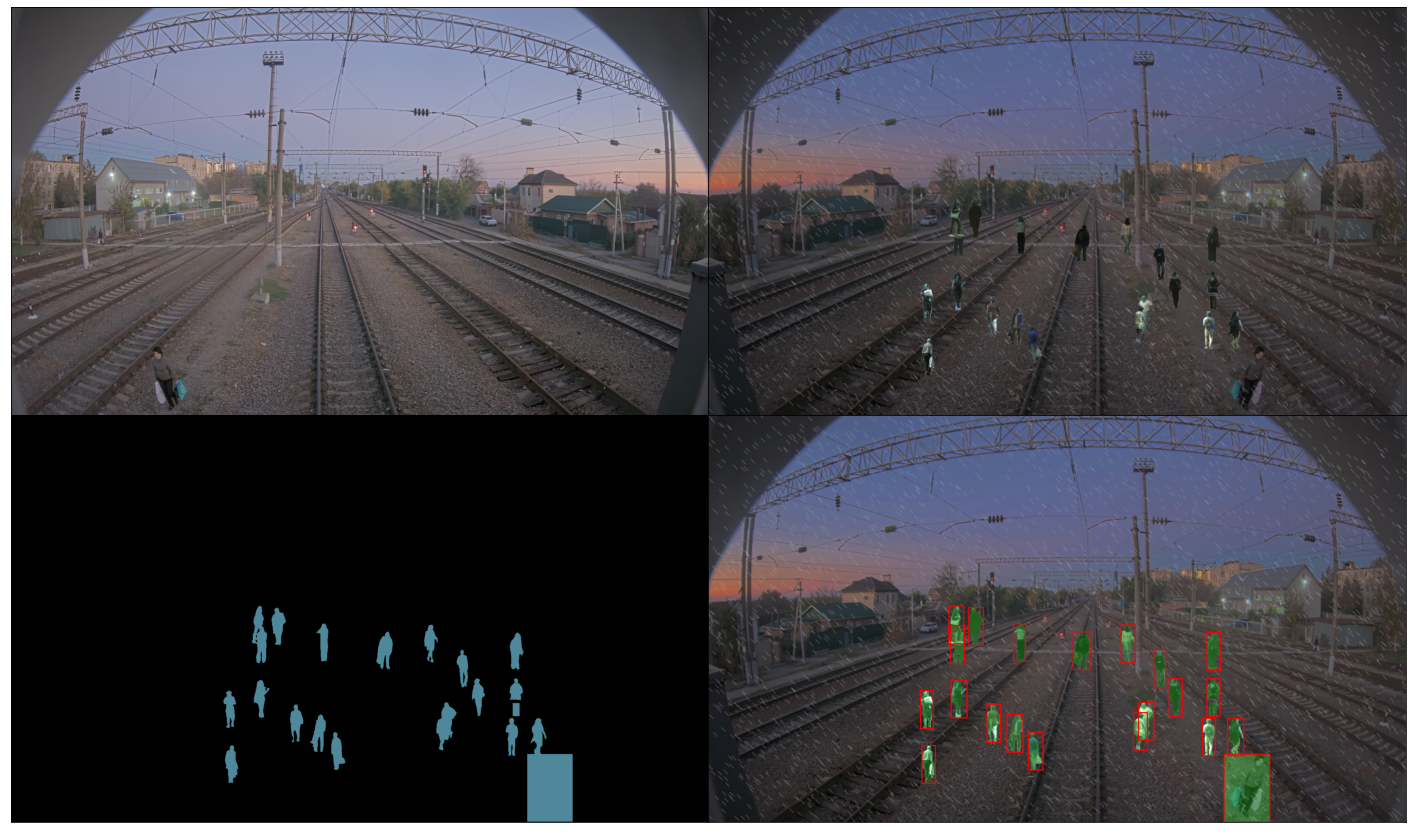

In [12]:
result_image_vis, result_mask_vis = draw_bboxes(transformed_image, result_coords, mask=transformed_mask)

show_image_and_masks(image, transformed_image, transformed_mask, result_image_vis, is_mask_semantic=True)

## Transform each object with albumentations

In [1]:
import cv2
import numpy as np
from pathlib import Path
from src.utils import show_image, draw_bboxes, show_image_and_masks
from src.cap_aug import CAP_AUG
import albumentations as A

In [6]:
DEST_DATASET_ROOT = Path('example_images/')
dest_image_name = 'img_900983.png'

dest_image_name = DEST_DATASET_ROOT / dest_image_name
image = cv2.imread(str(dest_image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

HUMAN_DATASET_ROOT = Path('data/human_dataset_filtered/')
SOURCE_IMAGES = sorted(list(HUMAN_DATASET_ROOT.glob('*.png')))
print(len(SOURCE_IMAGES))

2676


In [10]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur(always_apply=False, p=0.5, blur_limit=(7, 14)),
    A.InvertImg(always_apply=False, p=0.5),
])

cap_aug_pixels = CAP_AUG(SOURCE_IMAGES,  bev_transform=None, 
                                               n_objects_range=[10,20], 
                                               h_range=[100,101],
                                               x_range=[500, 1500],
                                               y_range=[600 ,1000],
                                               albu_transforms=transform)

In [11]:
result_image, result_coords, semantic_mask, instance_mask = cap_aug_pixels(image)

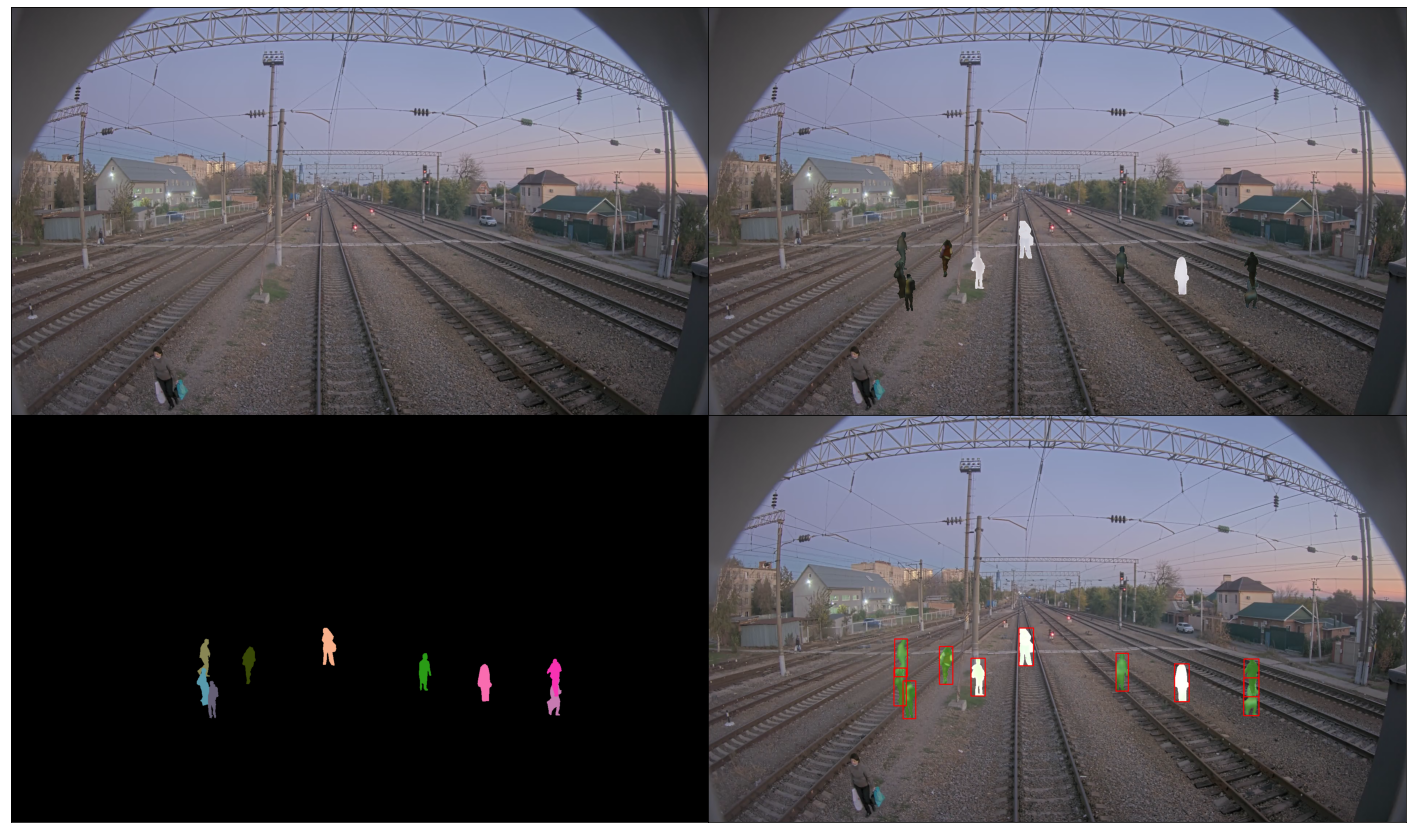

In [12]:
result_image_vis, result_mask_vis = draw_bboxes(result_image, result_coords, mask=semantic_mask)

show_image_and_masks(image, result_image, instance_mask, result_image_vis, is_mask_semantic=True)